In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import pysta
import stc

import os 

%load_ext autoreload
%autoreload 2

In [3]:
# load data

data_folder_name = "data"

# load stim and spike data
# dataset_name = "20180618"
# dataset_name = "20180621"
dataset_name = "20180626"
# dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, data_folder_name)

# dataset_filename = "data/{}.mat".format(dataset_name)
# stim, spike_train, info = pysta.load_data_mat(dataset_filename)

channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]
# info["channel_names"]

# load cell type
cell_types = pd.read_csv("{}/{}_cell_type.csv".format(data_folder_name, dataset_name))
# cell_types

['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['ch_12a', 'ch_12b', 'ch_12c', 'ch_13a', 'ch_13b', 'ch_13c', 'ch_13d', 'ch_13e', 'ch_14a', 'ch_14b', 'ch_14c', 'ch_14d', 'ch_16a', 'ch_16b', 'ch_16c', 'ch_17a', 'ch_17b', 'ch_17c', 'ch_17d', 'ch_21a', 'ch_21b', 'ch_21c', 'ch_21d', 'ch_21e', 'ch_22a', 'ch_22b', 'ch_23a', 'ch_23b', 'ch_23c', 'ch_23d', 'ch_25a', 'ch_25b', 'ch_25c', 'ch_26a', 'ch_26b', 'ch_26c', 'ch_26d', 'ch_27a', 'ch_27b', 'ch_27c', 'ch_27d', 'ch_28a', 'ch_28b', 'ch_28c', 'ch_31a', 'ch_31b', 'ch_31c', 'ch_31d', 'ch_32a', 'ch_32b', 'ch_32c', 'ch_33a', 'ch_33b', 'ch_33c', 'ch_33d', 'ch_35a', 'ch_35b', 'ch_35c', 'ch_35d', 'ch_35e', 'ch_35f', 'ch_35g', 'ch_36a', 'ch_36b', 'ch_36c', 'ch_36d', 'ch_37a', 'ch_37b', 'ch_37c', 'ch_37d', 'ch_37e', 'ch_38a', 'ch_41a', 'ch_41b', 'ch_41c', 'ch_41d', 'ch_42a', 'ch_42b', 'ch_42c', 'ch_43a', 'ch_43b', 'ch_43c', 'ch_45a', 'ch_45b', 'ch_45c', 'ch_46a', 'ch_46b', 'ch_47a', 'ch_48a', 'ch_48b', 'ch_48c', 

In [4]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": channel_names, "number_of_samples": num_samples})
# num_samples_df

## check the effect of smoothing on the largest eigenvalue($\lambda_1$)

In [4]:
# read eigenvalues

# helper function
def read_eigen_values(folder_name, channel_names):
    all_eig_values = dict()
    largest_eig_values = list()

    for channel_name in channel_names:
        filename = "{}/ch_{}_eig_val.txt".format(folder_name,channel_name)
        eig_val = np.loadtxt(filename)

        all_eig_values[channel_name] = eig_val
    #     eigen_values.append(eig_val)
        largest_eig_values.append(eig_val[0])
    return all_eig_values, largest_eig_values
    

folder_name = "{}_stc_tap{}".format(dataset_name,tap)
all_eig_values, largest_eig_values = read_eigen_values(folder_name, channel_names)
# convert to DataFrame
result_eig = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})

folder_name = "{}_stc_tap{}_smoothed".format(dataset_name,tap)
all_eig_values, largest_eig_values = read_eigen_values(folder_name, channel_names)
# convert to DataFrame
result_eig_smoothed = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})

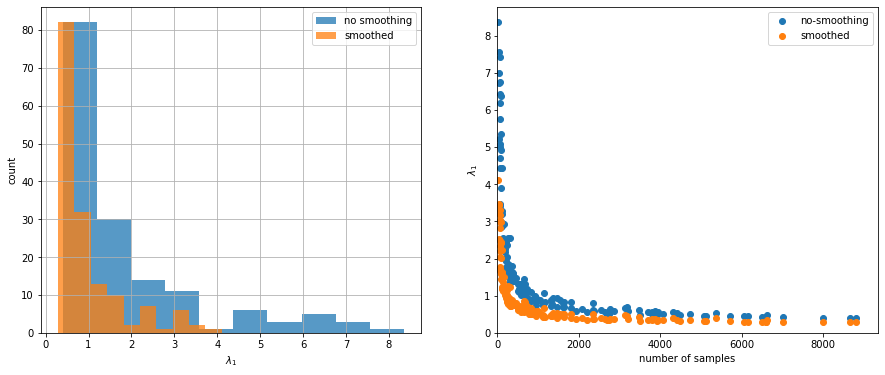

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(121)
result_eig["largest_eig_values"].hist(alpha=0.75)
result_eig_smoothed["largest_eig_values"].hist(alpha=0.75)
plt.grid("off")
plt.xlabel("$\lambda_1$")
plt.ylabel("count")

plt.legend(["no smoothing", "smoothed"])

plt.subplot(122)
# merge with num_samples
num_samples_eig = num_samples_df.merge(result_eig)
num_samples_eig_smoothed = num_samples_df.merge(result_eig_smoothed)

plt.scatter(num_samples_eig["number_of_samples"], num_samples_eig["largest_eig_values"])
plt.scatter(num_samples_eig_smoothed["number_of_samples"], num_samples_eig_smoothed["largest_eig_values"])
plt.xlabel('number of samples')
plt.ylabel('$\lambda_1$')
plt.xlim(0,plt.xlim()[1])
plt.ylim(0,plt.ylim()[1])


plt.legend(["no-smoothing", "smoothed"])
# see https://arxiv.org/pdf/0901.3245.pdf to understand the effect of # samples on the largest eigenvalue

plt.savefig("eig_smoothed_{}.pdf".format(dataset_name))

## Now, let's optimize the spatial smoothing parameter $\sigma$

In [6]:
tap = 8

spike_triggered_stim_all_channels, spike_count_all_channels = pysta.grab_spike_triggered_stim_all_channels(stim, spike_train,tap)

print(len(spike_triggered_stim_all_channels))

print(spike_triggered_stim_all_channels[0].shape)



156
(2868, 64, 8)


In [7]:
# calc sta

# choose channel
channel_name = "12a"
#channel_name = "14b"
#channel_name = "54a"
#channel_name = "33b"
#channel_name = "36c"  # for STC

ch_idx = pysta.find_channel_index(info["channel_names"], channel_name)

#sta = np.mean(spike_triggered_stim_all_channels[ch_idx],axis=0)
sta = np.average(spike_triggered_stim_all_channels[ch_idx], weights=spike_count_all_channels[ch_idx], axis=0)
print(sta.shape)

(64, 8)


0.49920854675892645 0.01998090262738869


Text(0.5, 1.0, '12a, mean=0.50, std=0.02')

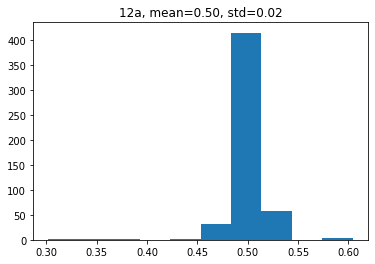

In [8]:
# calc mean and std of sta
m = np.mean(sta.ravel())
sig = np.std(sta.ravel())

print(m, sig)
plt.hist(sta.reshape([-1,1]))
plt.title("{}, mean={:.2f}, std={:.2f}".format(channel_name,m,sig))

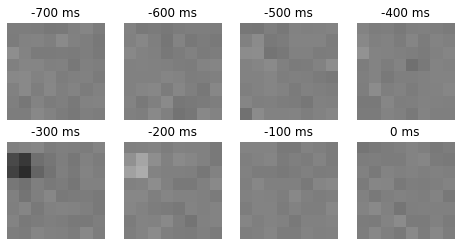

In [9]:
pysta.plot_stim_slices(sta, 8, 8, dt=100)
# plt.savefig

## stc

In [46]:
tap = 8
cov_algorithm="classic"

spatial_smoothing_sig = 0.25

save_folder_name = "results_"
os.makedirs(save_folder_name, exist_ok=True) 

from tqdm import tqdm

from scipy.stats import kurtosis

largest_eig_values = list()
kurtosis_coef = list()

print("Doing STC...")
for ch_idx in tqdm(range(spike_train.shape[0])):
    channel_name = info["channel_names"][ch_idx]
    # print(channel_name)

    # grab spike-triggered stim
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[ch_idx, :], tap)

    data = spike_triggered_stim
    num_samples = data.shape[0]
    weights = spike_count

    if spatial_smoothing_sig > 0:
        # spatial smoothing
#         sig = np.sqrt(0.25)
        data = pysta.smoothe_stim(data, spatial_smoothing_sig)

    # stack data into rows
    data_row = data.reshape([num_samples, -1])

    # centering by sta
    # data_centered, center = centering(data_row, weights)

    # center on all-half vector
    dim = data_row.shape[1]
    center = 0.5*np.ones((1,dim))
    data_centered = data_row - center

    # do STC
    eig_values, eig_vectors = stc.do_stc(data_centered, weights, cov_algorithm)
#     np.savetxt("{}/{}_eig_val.txt".format(save_folder_name, channel_name), eig_values)
    # np.savez_compressed("{}/{}_eig_vec.npz".format(folder_name, channel_name), eig_vectors)

    largest_eig_values.append(eig_values[0])

    # plot STC results
#     plot_stc_results(data_centered, eig_values, eig_vectors, save_folder_name, channel_name)
    # eigen_values.append(eig_values)

    # calc kurtosis of the 1st coef
    projected = stc.project(data_centered, eig_vectors[:, 0])    
    kurtosis_coef.append(kurtosis(projected))





  0%|          | 0/156 [00:00<?, ?it/s]

Doing STC...






  1%|          | 1/156 [00:01<04:10,  1.62s/it]



  1%|▏         | 2/156 [00:02<03:25,  1.33s/it]



  2%|▏         | 3/156 [00:02<02:29,  1.03it/s]



  3%|▎         | 4/156 [00:06<04:32,  1.79s/it]



  3%|▎         | 5/156 [00:06<03:28,  1.38s/it]



  4%|▍         | 6/156 [00:06<02:39,  1.07s/it]



  4%|▍         | 7/156 [00:07<02:02,  1.22it/s]



  5%|▌         | 8/156 [00:07<01:31,  1.62it/s]



  6%|▌         | 9/156 [00:07<01:24,  1.74it/s]



  6%|▋         | 10/156 [00:08<01:18,  1.87it/s]



  7%|▋         | 11/156 [00:08<01:02,  2.32it/s]



  8%|▊         | 12/156 [00:08<00:48,  2.96it/s]



  8%|▊         | 13/156 [00:09<01:02,  2.28it/s]



  9%|▉         | 14/156 [00:09<00:51,  2.76it/s]



 10%|▉         | 15/156 [00:09<00:41,  3.39it/s]



 10%|█         | 16/156 [00:10<01:32,  1.52it/s]



 11%|█         | 17/156 [00:11<01:16,  1.83it/s]



 12%|█▏        | 18/156 [00:11<01:01,  2.24it/s]



 12%|█▏        | 19/156 [00:11<00:47,  2.87it/s]



 13%|█▎        | 

KeyboardInterrupt: 

In [38]:
eig_values, eig_vectors = stc.do_stc(data_centered, weights, cov_algorithm, 1)

In [39]:
print(eig_values.shape)
print(eig_vectors.shape)

(1,)
(512, 1)


In [40]:
eig_values

array([0.57701686])

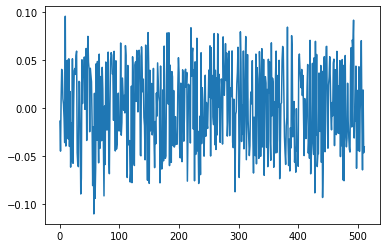

In [42]:
plt.plot(eig_vectors)

## batch
```
python3 stc_batch.py 20180626 --sigma 0.1 --tap 8
python3 stc_batch.py 20180626 --sigma 0.25 --tap 8
python3 stc_batch.py 20180626 --sigma 0.5 --tap 8
```

In [46]:
def read_largest_eigen_values(foldername, channel_names):
    largest_eig_values = list()
    for channel_name in channel_names:
        filename = "{}/ch_{}_eig_val.txt".format(folder_name,channel_name)
        eig_val = np.loadtxt(filename)

        largest_eig_values.append(eig_val[0])
    
    return largest_eig_values

sigs = [0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0] #, 3, 10]
#sigs = [0.1, 3]
largest_eig_values = list()
for sigma in sigs:
    folder_name = "20180626_sigma{:.3f}_tap8_stc_classic".format(sigma)
    # folder_name = "{}_stc_tap{}".format(dataset_name,tap)
    largest_eig_values.append(read_largest_eigen_values(folder_name, channel_names))

largest_eig_values = np.array(largest_eig_values)
# # convert to DataFrame
# result_eig = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})
# result_eig

Text(0, 0.5, '$\\lambda_1$')

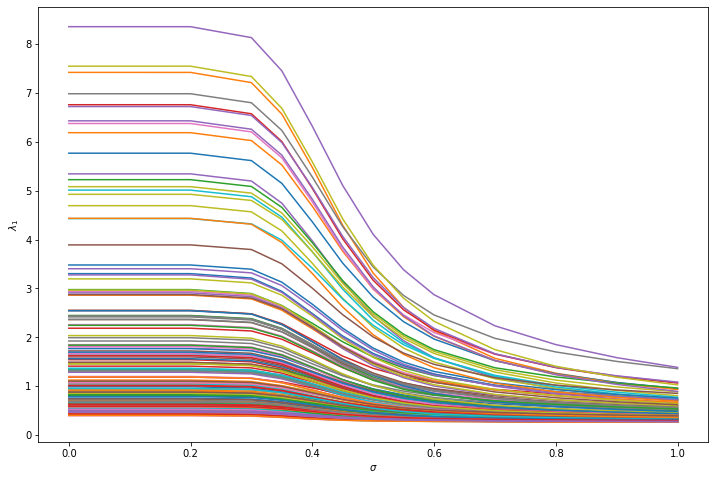

In [47]:
plt.figure(figsize=(12,8))
plt.plot(sigs, largest_eig_values)
plt.xlabel('$\sigma$')
plt.ylabel('$\lambda_1$')

## compare $c_1$ for a fixed channel 36_c

In [18]:
channel_name = "36c"  # ON/OFF cell
ch_idx = pysta.find_channel_index(info["channel_names"], channel_name)
print(ch_idx)

64


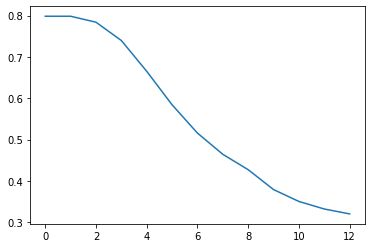

In [22]:
plt.plot(largest_eig_values[:,ch_idx])

(-0.5, 649.5, 499.5, -0.5)

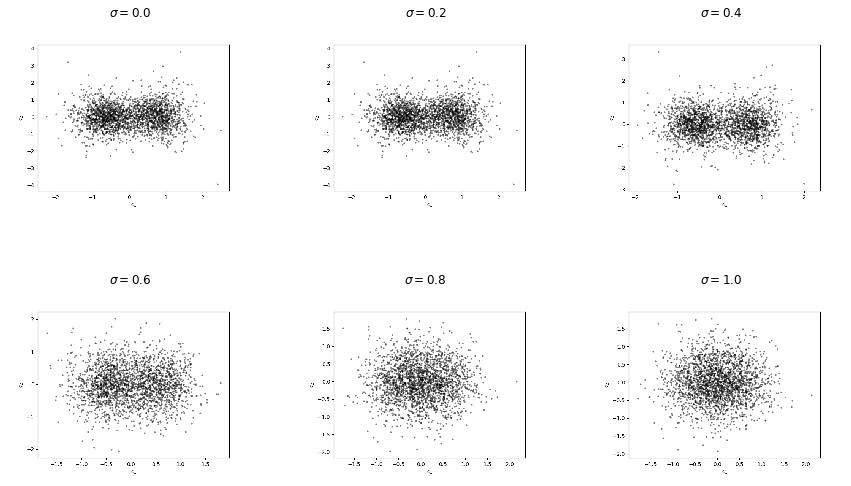

In [49]:
def read_projected(sigma, channel_name):
    folder_name = "20180626_sigma{:.3f}_tap8_stc_classic".format(sigma)
    filename = "{}/ch_{}_projected.png".format(folder_name,channel_name)
    return plt.imread(filename)

plt.figure(figsize=(15,9))
plt.subplot(231)
sigma = 0.0
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(232)
sigma = 0.2
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(233)
sigma = 0.4
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(234)
sigma = 0.6
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(235)
sigma = 0.8
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(236)
sigma = 1.0
plt.imshow(read_projected(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

(-0.5, 1999.5, 399.5, -0.5)

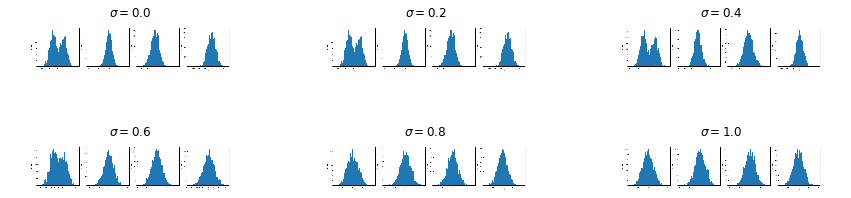

In [45]:
def read_projected_hist(sigma, channel_name):
    folder_name = "20180626_sigma{:.3f}_tap8_stc_classic".format(sigma)
    filename = "{}/ch_{}_projected_hist.png".format(folder_name,channel_name)
    return plt.imread(filename)

plt.figure(figsize=(15,4))
plt.subplot(231)
sigma = 0.0
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(232)
sigma = 0.2
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(233)
sigma = 0.4
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(234)
sigma = 0.6
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(235)
sigma = 0.8
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')

plt.subplot(236)
sigma = 1.0
plt.imshow(read_projected_hist(sigma, "36c"))
plt.title("$\sigma={}$".format(sigma))
plt.axis('off')